## 变分自编码器 (Variational Autoencoders, VAE)


### 导入模块

In [4]:
from autoencoder import *
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.nn as nn

### 下载数据集，并查看前6张图片

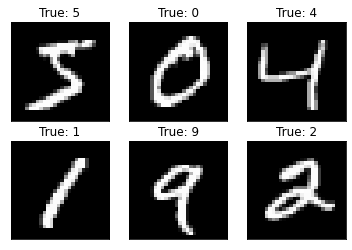

In [7]:
img_transform = transforms.Compose([
    transforms.ToTensor()])
path = "/Users/cynthiashi/Documents/DATA"
batch_size = 128
dataset = MNIST(path, transform=img_transform, train = True, download=False)
dataIter = DataLoader(dataset, batch_size=batch_size, shuffle=True)
imgs = dataset.data[:6].numpy()
labels = dataset.targets[:6].numpy()
 
_, axes = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        axes[i][j].imshow(imgs[i*3 + j], cmap='gray')
        axes[i][j].set_title("True: " + str(labels[i*3+j]))
        axes[i][j].get_xaxis().set_visible(False)
        axes[i][j].get_yaxis().set_visible(False)
plt.show()

### 定义VAE模型

In [12]:
class VAE(nn.Module):
    # 使用全链接网络
    def __init__(self, encoder_structure, decoder_structure, hidden_num):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential()
        for i in range(1, len(encoder_structure)):
            self.encoder.add_module("linear"+str(i), nn.Linear(encoder_structure[i-1], encoder_structure[i]))
            self.encoder.add_module("relu"+str(i), nn.ReLU())
 
        self.z_layer = nn.Linear(encoder_structure[-1], hidden_num)
        self.log_var_layer = nn.Linear(encoder_structure[-1], hidden_num)
 
        self.decoder = nn.Sequential()
        for i in range(1, len(decoder_structure)):
            self.decoder.add_module("linear"+str(i), nn.Linear(decoder_structure[i-1], decoder_structure[i]))
            if(i < len(decoder_structure)-1): self.decoder.add_module("relu"+str(i), nn.ReLU())
    
    def forward(self, x):
        self.z_mean, self.z_log_var = self.encode(x)
        z = self._reparameters(self.z_mean, self.z_log_var)
        self.x_mean = self.decode(z)
        return self.z_mean, self.z_log_var, z, self.x_mean
 
    def encode(self, x):
        code = self.encoder(x)
        z_mean = self.z_layer(code)
        z_log_var = self.log_var_layer(code)
        return z_mean, z_log_var
 
    def decode(self, z):
        x_mean = self.decoder(z)
        return x_mean
 
    def loss(self, x, recon_func):
        KL_loss = -0.5 * torch.sum(1 + self.z_log_var - self.z_mean.pow(2) - self.z_log_var.exp())
        recon_loss = recon_func(self.x_mean, x)
        return KL_loss + recon_loss
 
    def _reparameters(self, z_mean, z_log_var):
        z0 = torch.randn_like(z_mean)
        return z_mean + z0 * torch.exp(0.5*z_log_var)
    
    def train(self, net, dataIter, recon_loss, optimizer, epoches):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("training on %s" %(device))
        net = net.to(device)
        train_loss = [0.]*epoches
        for epoch in range(epoches):
            cnt = 0
            for batch_idx, (data, label) in enumerate(dataIter):
                # 前向
                data = data.view(data.size(0), -1).to(device)
                z_mean, z_log_var, z, x_mean = net(data)
                loss = net.loss(data, recon_loss)
                # 反向
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss[epoch] += loss.cpu().item()
                if((batch_idx+1) % 100 == 0):
                    print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                          .format(epoch, batch_idx, loss.cpu().item()/len(data)))
            # train_loss[epoch] /= len(dataIter.dataset)
            print("Epoch : {0} | epoch average loss : {1}"
                  .format(epoch, train_loss[epoch] / len(dataIter.dataset)))


### 定义模型并训练

In [13]:
encoder_structure = [784, 512, 64]
decoder_structure = [20, 64, 512, 784]
model = VAE(encoder_structure, decoder_structure, 20)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)
model.train(model, dataIter, nn.MSELoss(size_average=False), opt, 50)


VAE(
  (encoder): Sequential(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=512, out_features=64, bias=True)
    (relu2): ReLU()
  )
  (z_layer): Linear(in_features=64, out_features=20, bias=True)
  (log_var_layer): Linear(in_features=64, out_features=20, bias=True)
  (decoder): Sequential(
    (linear1): Linear(in_features=20, out_features=64, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=64, out_features=512, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=512, out_features=784, bias=True)
  )
)
training on cpu


/Users/cynthiashi/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch : 0 | #batch : 99 | batch average loss: 51.870418548583984
epoch : 0 | #batch : 199 | batch average loss: 46.789207458496094
epoch : 0 | #batch : 299 | batch average loss: 42.947021484375
epoch : 0 | #batch : 399 | batch average loss: 42.366119384765625
Epoch : 0 | epoch average loss : 46.12918159586589
epoch : 1 | #batch : 99 | batch average loss: 36.68184280395508
epoch : 1 | #batch : 199 | batch average loss: 36.81972885131836
epoch : 1 | #batch : 299 | batch average loss: 35.0137825012207
epoch : 1 | #batch : 399 | batch average loss: 34.21245574951172
Epoch : 1 | epoch average loss : 35.89617814941406
epoch : 2 | #batch : 99 | batch average loss: 35.59565734863281
epoch : 2 | #batch : 199 | batch average loss: 31.96639633178711
epoch : 2 | #batch : 299 | batch average loss: 33.02294158935547
epoch : 2 | #batch : 399 | batch average loss: 33.24359130859375
Epoch : 2 | epoch average loss : 33.42531871337891
epoch : 3 | #batch : 99 | batch average loss: 32.52182388305664
epoch 

epoch : 26 | #batch : 99 | batch average loss: 29.576892852783203
epoch : 26 | #batch : 199 | batch average loss: 30.355682373046875
epoch : 26 | #batch : 299 | batch average loss: 30.034847259521484
epoch : 26 | #batch : 399 | batch average loss: 29.28418731689453
Epoch : 26 | epoch average loss : 29.244936690266925
epoch : 27 | #batch : 99 | batch average loss: 28.516281127929688
epoch : 27 | #batch : 199 | batch average loss: 27.591190338134766
epoch : 27 | #batch : 299 | batch average loss: 28.531902313232422
epoch : 27 | #batch : 399 | batch average loss: 28.848400115966797
Epoch : 27 | epoch average loss : 29.207492724609374
epoch : 28 | #batch : 99 | batch average loss: 29.313846588134766
epoch : 28 | #batch : 199 | batch average loss: 29.81988525390625
epoch : 28 | #batch : 299 | batch average loss: 29.109294891357422
epoch : 28 | #batch : 399 | batch average loss: 29.522628784179688
Epoch : 28 | epoch average loss : 29.182102473958334
epoch : 29 | #batch : 99 | batch average l

### 随机采样几个编码，并生成样本

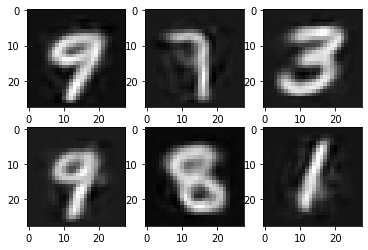

In [63]:
shape = (6, 20)
z_mean = torch.rand(shape)  # 均匀分布
rand_z = torch.randn(shape) + z_mean  # 标准正态分布
gen_x = model.decode(rand_z).cpu()
rand_img = gen_x.detach().numpy()
rand_img = ((rand_img - rand_img.min()) / (rand_img.max() - rand_img.min())*255).astype(np.uint8).reshape(-1,28,28)
# rand_img = (rand_img * 255 / (rand_img.max() - rand_img.min())).astype(np.uint8).reshape(-1,28,28)
_ ,axes = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        axes[i][j].imshow(rand_img[i*3+j], cmap='gray')
plt.show()